# Analysis presented in Tables
Here we process information that lead to tables useful for analyze the results.
First, we import all the important packages

In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import xgboost as xgb
import seaborn as sns
import astropy.units as u
from astropy.table import Table, join

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef

Additionally, we include some shortcuts to simplify some code

In [3]:
def create_table_cig(param_tab, samp, typ_agn):
    """Calculate the Matthews, Cohen, F1-macro and accuracy of the results"""
    for model in ['SKIRTOR', 'Fritz', 'S37', 'F37']:
        mcc = matthews_corrcoef(
            param_tab.loc[model][samp], param_tab.loc[model][typ_agn])
        f1s = f1_score(param_tab.loc[model][samp],
                       param_tab.loc[model][typ_agn], average='macro')
        acc = accuracy_score(param_tab.loc[model][samp], param_tab.loc[model][typ_agn])
        print(model, round(mcc, 3), round(f1s, 3), round(acc, 3))


def create_table_clas(param_tab, samp, typ_agn):
    """Calculate the Matthwes, Cohen, F1-macro and accuracy of the results from the Classifiers"""
    final_v = []
    for model in ['SKIRTOR', 'Fritz', 'S37', 'F37']:
        print(model)
        x_ini = param_tab.loc[model][samp]
        y_ini = param_tab.loc[model][typ_agn]
        x_train, x_test, y_train, y_test = train_test_split(x_ini,
                                                            y_ini,
                                                            test_size=0.20,
                                                            random_state=42)
        lab_enc = preprocessing.LabelEncoder()
        lab_enc.fit(y_ini)
        x_train_encode = preprocessing.robust_scale(x_train)
        x_test_encode = preprocessing.robust_scale(x_test)
        y_train_encode = lab_enc.transform(y_train).reshape(-1, 1).ravel()
        y_test_encode = lab_enc.transform(y_test).reshape(-1, 1).ravel()
        # This classifiers need to be defined before use
        for iclf, clasi in enumerate([clf_rf, clf_xg]):
            clasi.fit(x_train_encode, y_train_encode)
            mcc = matthews_corrcoef(
                y_test_encode, clasi.predict(x_test_encode))
            f1s = f1_score(y_test_encode, clasi.predict(
                x_test_encode), average='macro')
            acc = accuracy_score(y_test_encode, clasi.predict(x_test_encode))
            final_v.append([['RandomForest', 'XGBoost'][iclf], model,
                            round(mcc, 3), round(f1s, 3), round(acc, 3)])
    return np.array(final_v)


def selt1_or_selt2(tab_phot):
    """Select Seyferts 1 and 2 in both VCV and CDS"""
    selec1 = np.logical_and(tab_phot['otype_txt'] == 'Sy1', tab_phot['Sp'] == 'S1')
    selec2 = np.logical_and(tab_phot['otype_txt'] == 'Sy2', tab_phot['Sp'] == 'S2')
    select_sey = np.logical_or(selec1, selec2)
    return tab_phot[select_sey]

## Join all clean results

We read the results from the models we are going to use

In [4]:
ModelS = Table.read('../Data/Final/CIGALEOutputs/Cleanresults_SK.fits', format='fits')
ModelF = Table.read('../Data/Final/CIGALEOutputs/Cleanresults_Fr.fits', format='fits')

ModelS37 = Table.read('../Data/Final/CIGALEOutputs/Cleanresults_SK37.fits', format='fits')
ModelF37 = Table.read('../Data/Final/CIGALEOutputs/Cleanresults_Fr37.fits', format='fits')

We also read the original database of galaxies to use the information for the classification

In [5]:
Sample = Table.read('../Data/Final/VCV_SMB_otype.txt', format='ascii')
Sample.rename_column('main_id', 'id')  # Renamed to use the join with the same id

We join these clean tables with the catalog. We send all the tables to pandas format. Then, we concatenate the tables to have an unique table.

In [6]:
SPandas = join(Sample, ModelS, keys='id').to_pandas()
FPandas = join(Sample, ModelF, keys='id').to_pandas()
SPandas37 = join(Sample, ModelS37, keys='id').to_pandas()
FPandas37 = join(Sample, ModelF37, keys='id').to_pandas()
SFPandas = pd.concat([SPandas, FPandas, SPandas37, FPandas37],
                     keys=['SKIRTOR', 'Fritz', 'S37', 'F37'],
                     names=['Model', 'idCIG'])

## Feature selection
Here, we selected the features to use in the estimations for the analysis and predictions. First, we select the max number of useful features from CIGALE output.
We select the physical parameters in all the models and remove the ones that are not useful for our propose (e.g. constant values).

In [7]:
GoodColumns = [col for col in selt1_or_selt2(SFPandas).columns if 'bayes' in col]
newdf = selt1_or_selt2(SFPandas)[GoodColumns]
Descr = newdf.describe()
BadCol = [cl for cl in newdf.columns if Descr[cl]['std'] < 1e-2]  # Removing constant columns
newdf = newdf.drop(BadCol, axis=1)
# Removing calculated errors
BadCol2 = [cl for cl in newdf.columns if '_err' in cl]
newdf = newdf.drop(BadCol2, axis=1)
# Removing young estimations
BadCol3 = [cl for cl in newdf.columns if '_young' in cl]
# Removing old estimations
BadCol4 = [cl for cl in newdf.columns if '_old' in cl]
# Removing estimations with lines
BadCol5 = [cl for cl in newdf.columns if '_lines' in cl]
# Removing universe values, these are dependent of redshift
BadCol6 = [cl for cl in newdf.columns if 'universe' in cl]
# Removing filter in the attenuation module
BadCol7 = [cl for cl in newdf.columns if 'FUV' in cl]
BadCols = np.concatenate([BadCol3, BadCol4, BadCol5, BadCol6, BadCol7])
newdf = newdf.drop(BadCols, axis=1)
newdf = newdf.dropna(axis='columns')
newdf = newdf[newdf.columns[:-31]]  # Remove the mock photometry

We split the sample of galaxies into train and test sets. Then, we encode and scale the physical parameters.

In [8]:
x_ori = newdf
y_ori = selt1_or_selt2(SFPandas)['otype_txt']
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(x_ori, y_ori,
                                                            test_size=0.20,
                                                            random_state=42)
lab_enc_o = preprocessing.LabelEncoder()
lab_enc_o.fit(y_ori)
x_train_encode_o = preprocessing.robust_scale(x_train_o)
x_test_encode_o = preprocessing.robust_scale(x_test_o)
y_train_encode_o = lab_enc_o.transform(y_train_o).reshape(-1, 1).ravel()
y_test_encode_o = lab_enc_o.transform(y_test_o).reshape(-1, 1).ravel()

Principal Component Analysis (PCA) shows that only a few physical parameters are needed. More than ~6 if we made a cut at 99% on the variance ratio.

Text(0, 0.5, 'Cumulative explained variance')

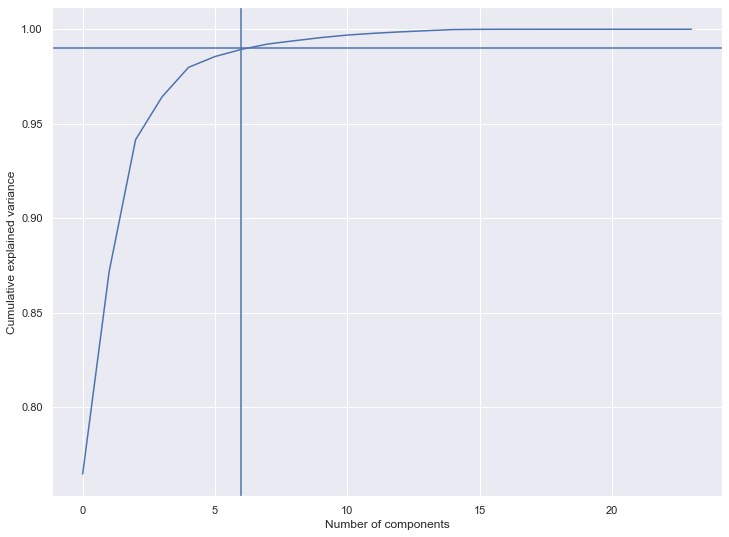

In [9]:
x_train_n = ((x_train_encode_o-x_train_encode_o.mean()) /
             (x_train_encode_o.max()-x_train_encode_o.min()))
# x_test_N = (x_test_encode-x_test_encode.mean())/(x_test_encode.max()-x_test_encode.min())

pca = PCA()
pca.fit(x_train_n)

sns.set()
plt.figure(1, figsize=(12, 9))
sns.lineplot(data=np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.99)
plt.axvline(x=6)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

We selected two different classifiers ([Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html)). We use the parameters values we found previously ([10_PreAnalysis](10_PreAnalysis.ipynb) notebook) from the classifiers .

In [10]:
clf_rf = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)
clf_xg = xgb.XGBClassifier(n_estimators=600, max_depth=15,
                           random_state=42, use_label_encoder=False, eval_metric='logloss')

We create a feature ranking with recursive feature elimination and cross-validated selection ([RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html)). We evaluate with the accuracy score and we use a 10-fold cross-validation.

In [11]:
rfecv_xg = RFECV(estimator=clf_xg, cv=StratifiedKFold(10),
                 scoring='f1_macro', verbose=4, min_features_to_select=6)
rfecv_xg = rfecv_xg.fit(x_train_encode_o, y_train_encode_o)
print('Optimal number of features :', rfecv_xg.n_features_)
print('Best features :', newdf.columns[rfecv_xg.support_])

Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 featu

Here the number of correct  classifications is still increasing with the number of features

Text(0, 0.5, 'Correct classifications')

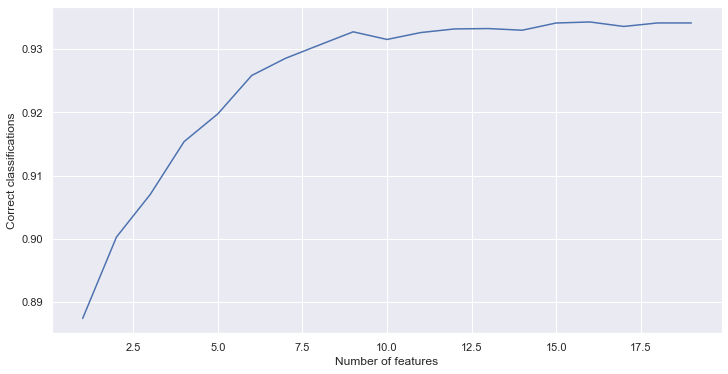

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(rfecv_xg.grid_scores_) + 1),
         rfecv_xg.grid_scores_)
plt.xlabel('Number of features')
plt.ylabel('Correct classifications')

In [13]:
rfecv_rf = RFECV(estimator=clf_rf, cv=StratifiedKFold(10),
                 scoring='f1_macro', min_features_to_select=6, verbose=4, n_jobs=-1)
rfecv_rf = rfecv_rf.fit(x_train_encode_o, y_train_encode_o)
print('Optimal number of features :', rfecv_rf.n_features_)
print('Best features :', newdf.columns[rfecv_rf.support_])

Optimal number of features : 24
Best features : Index(['bayes.agn.EBV', 'bayes.agn.fracAGN', 'bayes.agn.i',
       'bayes.attenuation.E_BVs', 'bayes.attenuation.powerlaw_slope',
       'bayes.dust.alpha', 'bayes.sfh.age', 'bayes.sfh.age_main',
       'bayes.sfh.tau_main', 'bayes.stellar.age_m_star',
       'bayes.agn.accretion_power', 'bayes.agn.disk_luminosity',
       'bayes.agn.dust_luminosity', 'bayes.agn.intrin_Lnu_2500A',
       'bayes.agn.luminosity', 'bayes.dust.luminosity', 'bayes.sfh.integrated',
       'bayes.sfh.sfr', 'bayes.sfh.sfr100Myrs', 'bayes.sfh.sfr10Myrs',
       'bayes.stellar.lum', 'bayes.stellar.lum_ly', 'bayes.stellar.m_gas',
       'bayes.stellar.m_star'],
      dtype='object')


Here the number of correct classifications also increasing with the number of features

Text(0, 0.5, 'Correct classifications')

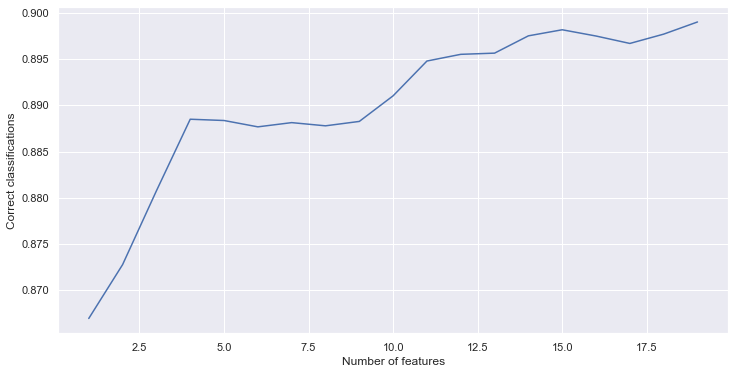

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(rfecv_rf.grid_scores_) + 1),
         rfecv_rf.grid_scores_)
plt.xlabel('Number of features')
plt.ylabel('Correct classifications')

We can verify the mean feature importance to select the most important physical parameters.

In [15]:
XGBFI = pd.Series(rfecv_xg.estimator_.feature_importances_, name='XGB',
                  index=newdf.columns[rfecv_xg.support_].array)
RFFI = pd.Series(rfecv_rf.estimator_.feature_importances_, name='RandomForest',
                 index=newdf.columns[rfecv_rf.support_].array)

This shows there are 2 features that contributes the most (>10%:AGN disk luminosity and viewing angle), 3 that contribute a considerable amount (5-7%: AGN E(B-V), attenuration E(B-V)s and $\tau_{main}$) and finally the rest parameters where the contribution is almost negligible (<3%).

In [16]:
feat_imp = pd.concat([RFFI, XGBFI], axis=1)
feat_imp['mean'] = feat_imp.mean(axis=1, skipna=False)
print(feat_imp.sort_values(by='mean', ascending=False))

                                  RandomForest       XGB      mean
bayes.agn.disk_luminosity             0.168389  0.352865  0.260627
bayes.agn.i                           0.196726  0.097223  0.146974
bayes.agn.EBV                         0.085788  0.041232  0.063510
bayes.attenuation.E_BVs               0.063450  0.062322  0.062886
bayes.sfh.tau_main                    0.053326  0.053334  0.053330
bayes.agn.luminosity                  0.046127  0.018828  0.032478
bayes.sfh.sfr                         0.032584  0.025933  0.029259
bayes.agn.dust_luminosity             0.024423  0.030446  0.027434
bayes.stellar.age_m_star              0.024041  0.030406  0.027224
bayes.sfh.integrated                  0.016807  0.034115  0.025461
bayes.agn.fracAGN                     0.019848  0.028832  0.024340
bayes.dust.alpha                      0.022563  0.024821  0.023692
bayes.sfh.sfr100Myrs                  0.027336  0.019681  0.023509
bayes.sfh.age                         0.019930  0.025829  0.02

We selected 7 parameters from these list to do the calculations. We include the 5 parameters with a high feature importance (the ones mentioned before) and we add the star-formation rate (SFR) and the AGN fraction ($f_{AGN}$). These two parameters can give us a better comparison with observational results, and at the same time improve the classification task.

In [17]:
ManualCols = np.array(['bayes.agn.i',
                       'bayes.agn.fracAGN',
                       'bayes.agn.disk_luminosity',
                       'bayes.agn.EBV',
                       'bayes.attenuation.E_BVs',
                       'bayes.sfh.sfr',
                       'bayes.sfh.tau_main'])

##### FIGURE 4
Finally, we present the feature importance data in a plot to observe how different the parameters are.

<Figure size 486x391.68 with 0 Axes>

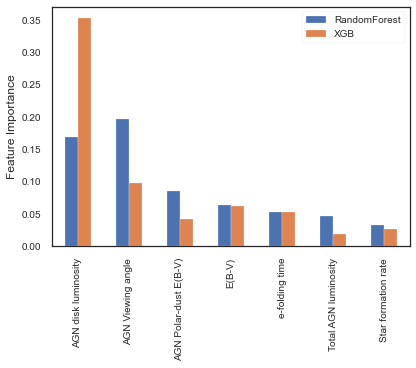

In [18]:
fe_im = feat_imp.sort_values(by='mean', ascending=False)[:7]
sns.set_style("white")
# with plt.style.context('seaborn-talk'):
with plt.style.context('seaborn-paper'):
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'axes.labelsize': 12})
    plt.rcParams.update({'legend.fontsize': 10})
    plt.rcParams.update({'ytick.labelsize': 10})
    plt.rcParams.update({'xtick.labelsize': 10})
    plt.figure(figsize=(6.75, 5.44))
    fe_im.plot.bar(y=['RandomForest', 'XGB'], rot=90)
    plt.ylabel('Feature Importance')
    plt.xticks(np.arange(7), ('AGN disk luminosity',
                              'AGN Viewing angle',
                              'AGN Polar-dust E(B-V)',
                              'E(B-V)',
                              'e-folding time',
                              'Total AGN luminosity',
                              'Star formation rate'))
    plt.savefig('../Figures/F4.pdf', dpi=300, bbox_inches='tight')  # For Paper
#     plt.savefig('../Talk_Figures/F4.png',dpi=300,bbox_inches = 'tight') # For Presentation

## Correlation score with CIGALE parameters

We define some selection defitions to be used for the classification task

In [19]:
def selt1_t2_smb(tab_phot):
    """Select Seyfert 1 and 2 types from SMB"""
    select_sey = np.logical_or(tab_phot['otype_txt'] == 'Sy1',
                               tab_phot['otype_txt'] == 'Sy2')
    return tab_phot[select_sey]


def selt1_t2_vcv(tab_phot):
    """Select Seyfert 1 and 2 types from VCV"""
    select_sey = np.logical_or(tab_phot['Sp'] == 'S1', tab_phot['Sp'] == 'S2')
    return tab_phot[select_sey]

def selt1_xor_selt2(tab_phot):
    """Select mixed classifications Seyferts 1 and 2 between VCV and CDS"""
    selec1 = np.logical_and(tab_phot['otype_txt'] == 'Sy1', tab_phot['Sp'] == 'S2')
    selec2 = np.logical_and(tab_phot['otype_txt'] == 'Sy2', tab_phot['Sp'] == 'S1')
    select_sey = np.logical_or(selec1, selec2)
    return tab_phot[select_sey]


def selt1_or_t2_vcv(tab_phot):
    """Select numeric Seyfert types in VCV"""
    selc1 = np.logical_and(tab_phot['otype_txt'] ==
                           'Sy1', tab_phot['Sp'] == 'S1.0')
    selc2 = np.logical_and(tab_phot['otype_txt'] ==
                           'Sy1', tab_phot['Sp'] == 'S1.2')
    selc3 = np.logical_and(tab_phot['otype_txt'] ==
                           'Sy1', tab_phot['Sp'] == 'S1.5')
    selc4 = np.logical_and(tab_phot['otype_txt'] ==
                           'Sy2', tab_phot['Sp'] == 'S1.8')
    selc5 = np.logical_and(tab_phot['otype_txt'] ==
                           'Sy2', tab_phot['Sp'] == 'S1.9')
    select_sey = np.logical_or.reduce([selc1, selc2, selc3, selc4, selc5])
    return tab_phot[select_sey]


def selt1_nor_t2(tab_phot):
    """Select all other types in VCV"""
    i_sec = np.logical_and.reduce([tab_phot['Sp'] != 'S1', tab_phot['Sp'] != 'S2',
                                   tab_phot['Sp'] != 'S1.0', tab_phot['Sp'] != 'S1.2',
                                   tab_phot['Sp'] != 'S1.5', tab_phot['Sp'] != 'S1.8',
                                   tab_phot['Sp'] != 'S1.9'])
    return tab_phot[i_sec]

If we assume that some of the outputs parameters from CIGALE can be used for the classification task, we can classify (flag) galaxies in Type-1 or Type-2. We selected the viewing angle and the AGN disk luminosity for the classification task. We set a limit in the viewing angle at 45 degrees (does not evolve with redshift), and we define a polynomial fit $8.943 + 6.311 z -5.314 z^2$ (Check [FIGURE 8](../Figures/F8.pdf) and/or [12_Analysis_Plots](12_Analysis_Plots.ipynb) notebook) in the range of z<=0.6 to separate the two types. For higher redshifts we assume the value at z=0.6,. We also test what happen if we assume that numerical types from VCV are close to the respective type 1 or 2.

In [44]:
def sep_sey_typ(redshift):
    """Polynomial fit for the separation in AGN disk luminosity between Seyfert Types"""
    return 8.943 + 6.311*redshift - 5.314*redshift**2

In [45]:
# Log-value of the AGN disk luminosity at z>0.6
print(sep_sey_typ(0.6))

10.816559999999999


In [46]:
# Separating following the viewing angle
SFPandas['TypeAGN_CIG_i'] = np.empty(len(SFPandas))
SFPandas.loc[SFPandas['bayes.agn.i'] < 45, 'TypeAGN_CIG_i'] = 'Sy1'
SFPandas.loc[SFPandas['bayes.agn.i'] >= 45, 'TypeAGN_CIG_i'] = 'Sy2'
SFPandas['TypeAGN_CIG_i2'] = np.empty(len(SFPandas))
SFPandas.loc[SFPandas['bayes.agn.i'] < 45, 'TypeAGN_CIG_i2'] = 'S1'
SFPandas.loc[SFPandas['bayes.agn.i'] >= 45, 'TypeAGN_CIG_i2'] = 'S2'

# Separating following the AGN disk luminosity
SFPandas['TypeAGN_CIG_Ldisk'] = np.empty(len(SFPandas))
zSF = SFPandas['rvz_redshift']
ValueSeparatation = (10**sep_sey_typ(zSF.values) * u.solLum).to(u.W).value
ValueSeparatation[zSF > 0.6] = (10**sep_sey_typ(0.6) * u.solLum).to(u.W).value
SFPandas.loc[SFPandas['bayes.agn.disk_luminosity'] > ValueSeparatation,
             'TypeAGN_CIG_Ldisk'] = 'Sy1'
SFPandas.loc[SFPandas['bayes.agn.disk_luminosity'] <= ValueSeparatation,
             'TypeAGN_CIG_Ldisk'] = 'Sy2'
SFPandas['TypeAGN_CIG_Ldisk2'] = np.empty(len(SFPandas))
SFPandas.loc[SFPandas['bayes.agn.disk_luminosity'] > ValueSeparatation,
             'TypeAGN_CIG_Ldisk2'] = 'S1'
SFPandas.loc[SFPandas['bayes.agn.disk_luminosity'] <= ValueSeparatation,
             'TypeAGN_CIG_Ldisk2'] = 'S2'

# Separating assuming numerical types close to types 1 and 2
SFPandas['TypeAGN_VCV'] = np.empty(len(SFPandas))
SFPandas.loc[np.logical_or.reduce([SFPandas['Sp'] == 'S1.0', SFPandas['Sp'] == 'S1.2']),
             'TypeAGN_VCV'] = 'S1'
SFPandas.loc[np.logical_or.reduce([SFPandas['Sp'] == 'S1.8',
                                   SFPandas['Sp'] == 'S1.9', SFPandas['Sp'] == 'S1.5']),
             'TypeAGN_VCV'] = 'S2'

We test how much the metric scores will change if we select only one of the classifications, for the viewing angle

In [47]:
create_table_cig(selt1_t2_smb(SFPandas), 'otype_txt', 'TypeAGN_CIG_i')
create_table_cig(selt1_t2_vcv(SFPandas), 'Sp', 'TypeAGN_CIG_i2')

SKIRTOR 0.524 0.753 0.818
Fritz 0.463 0.72 0.791
S37 0.564 0.773 0.836
F37 0.506 0.731 0.799
SKIRTOR 0.54 0.761 0.826
Fritz 0.485 0.73 0.803
S37 0.573 0.776 0.841
F37 0.514 0.733 0.804


We check also how bad it will be the classifier by selecting mixed classifications

In [48]:
create_table_cig(selt1_xor_selt2(SFPandas), 'Sp', 'TypeAGN_CIG_i2')
create_table_cig(selt1_xor_selt2(SFPandas), 'otype_txt', 'TypeAGN_CIG_i')

SKIRTOR 0.067 0.399 0.436
Fritz 0.102 0.399 0.433
S37 0.015 0.346 0.369
F37 0.112 0.314 0.319
SKIRTOR -0.067 0.431 0.564
Fritz -0.102 0.418 0.567
S37 -0.015 0.467 0.631
F37 -0.112 0.439 0.681


When using the intermediate classfication

In [49]:
create_table_cig(selt1_or_t2_vcv(SFPandas), 'TypeAGN_VCV', 'TypeAGN_CIG_i2')

SKIRTOR 0.214 0.555 0.582
Fritz 0.071 0.523 0.529
S37 0.221 0.538 0.576
F37 0.154 0.547 0.559


Interestingly, when using the split by the AGN disk luminosity we obtain a better constraint

In [50]:
create_table_cig(selt1_t2_smb(SFPandas), 'otype_txt', 'TypeAGN_CIG_Ldisk')
create_table_cig(selt1_t2_vcv(SFPandas), 'Sp', 'TypeAGN_CIG_Ldisk2')

SKIRTOR 0.6 0.791 0.847
Fritz 0.526 0.76 0.835
S37 0.596 0.789 0.85
F37 0.506 0.749 0.835
SKIRTOR 0.6 0.789 0.844
Fritz 0.519 0.754 0.831
S37 0.597 0.787 0.848
F37 0.501 0.744 0.832


##### Part TABLE 4
Finally, we choose galaxies where SMB and VCV give the same classification. We use this values for comparing with the XGBoost and RandomForest methods. This values are the first part of Table 4.

In [51]:
# As these are in both samples it does not matter if we use 'otype_txt' or 'Sp'
create_table_cig(selt1_or_selt2(SFPandas), 'otype_txt', 'TypeAGN_CIG_i')
create_table_cig(selt1_or_selt2(SFPandas), 'otype_txt', 'TypeAGN_CIG_Ldisk')

SKIRTOR 0.556 0.771 0.835
Fritz 0.499 0.739 0.811
S37 0.594 0.788 0.851
F37 0.53 0.744 0.815
SKIRTOR 0.622 0.801 0.855
Fritz 0.539 0.765 0.84
S37 0.62 0.8 0.859
F37 0.52 0.755 0.842


## Correlation score with with Machine Learning algorithms
##### Part TABLE 4
We fit the classifiers  with the selected columns. We present the mean feature importance of each of them, together with the same values presented before.

In [52]:
TABLE4 = create_table_clas(selt1_or_selt2(SFPandas), ManualCols, 'otype_txt')

SKIRTOR
Fritz
S37
F37


In [53]:
Table(TABLE4).group_by('col0')

col0,col1,col2,col3,col4
str12,str12,str12,str12,str12
RandomForest,SKIRTOR,0.713,0.855,0.906
RandomForest,Fritz,0.716,0.856,0.906
RandomForest,S37,0.686,0.842,0.903
RandomForest,F37,0.659,0.83,0.907
XGBoost,SKIRTOR,0.702,0.85,0.903
XGBoost,Fritz,0.664,0.831,0.891
XGBoost,S37,0.612,0.805,0.881
XGBoost,F37,0.63,0.815,0.9


The <tt> DummyClassifier </tt> was used to check the baseline for the metrics in the predictions when using random configurations. So this can be seem as when the classifier gives bad/none results. This numbers are the last part of TABLE 4.

In [54]:
Dclf = DummyClassifier(strategy='stratified', random_state=42)
# We use all the AGN models, not the train and test samples (It does not matter which one we use)
Dclf.fit(x_ori, y_ori)
DumPred = Dclf.predict(x_ori)

print('DummyClassifier', round(matthews_corrcoef(y_ori, DumPred), 3),
      round(f1_score(y_ori, DumPred, average='macro'), 3),
      round(accuracy_score(y_ori, DumPred), 3))

DummyClassifier -0.0 0.5 0.695


## Predict the type of Seyfert in unclassified galaxies
Here we select the galaxies with an undefined type (or unknown source) and we predict the type AGN. We compare with just selecting the AGN disk luminosity from CIGALE. As we saw before, the AGN disk luminosity is better in predict the classifications (first part of the TABLE 4).

In [55]:
SFPandas['CIG_Pred'] = np.empty(len(SFPandas))*np.nan
SFPandas.loc[SFPandas['bayes.agn.disk_luminosity'] > ValueSeparatation,
             'CIG_Pred'] = 0
SFPandas.loc[SFPandas['bayes.agn.disk_luminosity'] <= ValueSeparatation,
             'CIG_Pred'] = 1

We then select two types, one where there is no class associated in VCV and SMB, and another when there is no class in VCV or SMB.

In [56]:
NoClass = SFPandas[np.logical_and(
    SFPandas['otype_txt'] == 'SyG', SFPandas['Sp'] == 'S')]
SemiClass = SFPandas[np.logical_xor(
    SFPandas['otype_txt'] == 'SyG', SFPandas['Sp'] == 'S')]

In [57]:
print('Total number of galaxies without a class in neither VCV and SMB and a good fitting:',
      len(np.unique(NoClass['id'])))
print('Total number of galaxies without a class in VCV or SMB and a good fitting:',
      len(np.unique(SemiClass['id'])))

Total number of galaxies without a class in neither VCV and SMB and a good fitting: 16
Total number of galaxies without a class in VCV or SMB and a good fitting: 49


We create a function to analyze these results in a table

In [58]:
def create_table_clas_mod(train_table, pred_table, samp, typ_agn):
    """Precict the type of the unknown Seyferts """
    col_pred1 = []
    col_pred2 = []
    for model in ['SKIRTOR', 'Fritz', 'S37', 'F37']:
        x_ini = train_table.loc[model][samp]
        y_ini = train_table.loc[model][typ_agn]
        x_pre = pred_table.loc[model][samp]
        x_train, _, y_train, _ = train_test_split(x_ini, y_ini, test_size=0.20, random_state=42)
        lab_enc = preprocessing.LabelEncoder()
        lab_enc.fit(y_ini)
        x_train_encode = preprocessing.robust_scale(x_train)
        y_train_encode = lab_enc.transform(y_train).reshape(-1, 1).ravel()
        # These classifiers need to be defined before use
        for iclf, clasi in enumerate([clf_rf, clf_xg]):
            print(['RF', 'XGB'][iclf], model)
            clasi.fit(x_train_encode, y_train_encode)
            x_pre_encode = preprocessing.robust_scale(x_pre)
            y_pre = clasi.predict(x_pre_encode)
            if iclf == 0:
                col_pred1 = np.concatenate((col_pred1, y_pre), axis=None)
            else:
                col_pred2 = np.concatenate((col_pred2, y_pre), axis=None)
    pred_table['RF_Pred'] = col_pred1
    pred_table['XGB_Pred'] = col_pred2
    return pred_table

In [59]:
ClassSec = create_table_clas_mod(selt1_or_selt2(SFPandas), NoClass, ManualCols, 'otype_txt')
ClassSec2 = create_table_clas_mod(selt1_or_selt2(SFPandas), SemiClass, ManualCols, 'otype_txt')

RF SKIRTOR
XGB SKIRTOR
RF Fritz
XGB Fritz
RF S37
XGB S37
RF F37
XGB F37


<ipython-input-58-093b5ce43c24>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_table['RF_Pred'] = col_pred1
<ipython-input-58-093b5ce43c24>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_table['XGB_Pred'] = col_pred2


RF SKIRTOR
XGB SKIRTOR
RF Fritz
XGB Fritz
RF S37
XGB S37
RF F37
XGB F37


<ipython-input-58-093b5ce43c24>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_table['RF_Pred'] = col_pred1
<ipython-input-58-093b5ce43c24>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_table['XGB_Pred'] = col_pred2


As there are four models in this work, we assume that all of them should give the same (or close to) classification in the final type. And we use the mean to represent these values.

In [60]:
TypeTab = Table.from_pandas(ClassSec[['id', 'otype_txt', 'RF_Pred', 'XGB_Pred',
                                      'CIG_Pred']]).group_by('id').groups.aggregate(np.mean)

In [61]:
TypeTab2 = Table.from_pandas(ClassSec2[['id', 'otype_txt', 'RF_Pred', 'XGB_Pred',
                                        'CIG_Pred']]).group_by('id').groups.aggregate(np.mean)

In [62]:
TypeTab['ML_Pred'] = np.mean([TypeTab['RF_Pred'], TypeTab['XGB_Pred']], axis=0)
TypeTab2['ML_Pred'] = np.mean([TypeTab2['RF_Pred'], TypeTab2['XGB_Pred']], axis=0)

##### TABLE 5
We predict the class depending on the average/mean of all the classifications trained in this work. The zeros values mean Sy1 while the ones are Sy2. For the galaxies without any classification we found that 2 would be Sy2, 8 would be Sy1 and the rest (6) are still difficult to classify.

In [63]:
TypeTab

id,RF_Pred,XGB_Pred,CIG_Pred,ML_Pred
str23,float64,float64,float64,float64
2MASX J12140343-1921428,0.0,0.0,0.0,0.0
2MASX J18121404+2153047,0.0,0.0,1.0,0.0
2MASX J20075080+5938105,1.0,0.6666666666666666,0.6666666666666666,0.8333333333333333
2MASX J21560047-2144325,0.0,0.0,0.0,0.0
2MASX J23032790+1443491,0.0,0.0,0.0,0.0
2XMM J094233.5+470213,0.0,0.0,1.0,0.0
2XMM J105045.9+571732,0.0,0.0,1.0,0.0
CADIS 16-505716,0.0,0.25,0.0,0.125
ESO 373-13,0.5,0.5,1.0,0.5


For the galaxies with at least one classification, we found 41/49 Seyfert 1 galaxies. We discuss the results of the classifications in the paper.

In [64]:
join(TypeTab2[:20], Sample['id', 'Sp', 'otype_txt'])

id,RF_Pred,XGB_Pred,CIG_Pred,ML_Pred,Sp,otype_txt
str35,float64,float64,float64,float64,str4,str3
2E 2294,0.0,0.0,0.0,0.0,S1,SyG
2E 2628,0.0,0.0,0.0,0.0,S1.5,SyG
2E 3786,0.0,0.0,0.0,0.0,S1.0,SyG
2MASS J00423990+3017514,0.0,0.0,0.0,0.0,S1.5,SyG
2MASS J01341936+0146479,0.0,0.0,0.0,0.0,S1.0,SyG
2MASS J02500703+0025251,0.0,0.0,0.0,0.0,S,Sy1
2MASS J08171856+5201477,0.0,0.0,1.0,0.0,S,Sy1
2MASS J09393182+5449092,0.0,0.0,0.0,0.0,S,Sy1
2MASS J09455439+4238399,0.0,0.0,0.0,0.0,S,Sy2


In [65]:
join(TypeTab2[20:40], Sample['id', 'Sp', 'otype_txt'])

id,RF_Pred,XGB_Pred,CIG_Pred,ML_Pred,Sp,otype_txt
str35,float64,float64,float64,float64,str4,str3
2MASX J09420770+0228053,0.0,0.0,0.0,0.0,S2,SyG
2MASX J09443702-2633554,0.0,0.0,0.0,0.0,S1.5,SyG
2MASX J09483841+4030436,0.25,0.75,0.75,0.5,S,Sy1
2MASX J10155660-2002268,0.25,0.0,0.0,0.125,S1,SyG
2MASX J10194946+3322041,0.0,0.0,0.0,0.0,S,Sy2
2MASX J15085291+6814074,0.0,0.0,0.0,0.0,S1.8,SyG
2MASX J16383091-2055246,0.5,0.5,0.0,0.5,S1,SyG
2MASX J21512498-0757558,0.75,1.0,1.0,0.875,S,Sy1
2MASX J22024516-1304538,0.0,0.0,0.0,0.0,S1.8,SyG


In [66]:
join(TypeTab2[40:], Sample['id', 'Sp', 'otype_txt'])

id,RF_Pred,XGB_Pred,CIG_Pred,ML_Pred,Sp,otype_txt
str35,float64,float64,float64,float64,str4,str3
ICRF J100646.4-215920,0.0,0.0,0.0,0.0,S1.0,SyG
ICRF J110153.4+624150,0.0,0.0,0.0,0.0,S1.5,SyG
ICRF J135704.4+191907,0.0,0.0,0.0,0.0,S1.5,SyG
IRAS 10295-1831,0.25,0.25,0.0,0.25,S1.5,SyG
MCG+03-60-031,1.0,1.0,0.5,1.0,S1,SyG
MCG+05-28-032,0.0,0.0,0.0,0.0,S3,SyG
Mrk 1361,1.0,1.0,0.5,1.0,S,Sy2
PB 162,0.0,0.0,0.0,0.0,S,Sy1
UGC 10683,1.0,1.0,0.0,1.0,S1.5,SyG


##### Notebook info

In [43]:
%load_ext watermark
%watermark -a "Andres Ramos" -d -v -m
print('Specific Python packages')
%watermark -iv -w

Author: Andres Ramos

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 3.10.0-1160.25.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
numpy     : 1.19.5
re        : 2.2.1
matplotlib: 3.2.2
autopep8  : 1.5.7
json      : 2.0.9
sys       : 3.8.3 (default, Jul  2 2020, 16:21:59) 
[GCC 7.3.0]
pandas    : 1.2.0
astropy   : 4.2
sklearn   : 0.23.1
xgboost   : 1.3.3
seaborn   : 0.11.1
logging   : 0.5.1.2

Watermark: 2.1.0

